In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.0.0'

In [5]:
tf.random.set_seed(42)

### 生成数据

In [71]:
def fx(x):
    w = tf.constant([4,-3],dtype=tf.float32)
    
    return tf.reduce_sum(x*w,axis=1)+5.0 + tf.random.normal(shape=(x.shape[0],))

In [72]:
x = tf.random.normal(shape=(1000,2))
y = fx(x)

In [73]:
y

<tf.Tensor: id=2273451, shape=(1000,), dtype=float32, numpy=
array([ 1.01861877e+01,  6.14771080e+00,  2.87886739e+00, -1.20707870e-01,
        6.56943977e-01, -2.39518166e+00, -6.67415762e+00,  2.22801280e+00,
        8.79686928e+00,  5.51824474e+00,  1.90954089e-01,  1.37714005e+00,
        5.66618299e+00,  5.24833298e+00,  1.05222826e+01,  6.79739237e+00,
        1.16152086e+01,  9.00186062e+00,  4.56649160e+00,  6.67872047e+00,
        7.98931313e+00,  4.29794884e+00,  1.99758232e-01, -3.15370560e-01,
        7.13882399e+00,  9.88368225e+00,  6.36349916e+00,  5.32464838e+00,
       -1.03326082e+00,  1.12593012e+01,  8.99102592e+00, -7.21931338e-01,
       -2.51153660e+00,  4.45999050e+00,  8.74665356e+00,  1.11138105e+01,
        5.51464701e+00, -6.66048765e+00,  8.93986702e-01,  3.79797077e+00,
        7.56678581e+00,  6.72136450e+00,  6.10357189e+00,  9.84549141e+00,
       -1.08767211e+00, -8.92275238e+00,  5.46188164e+00,  7.16438627e+00,
        8.68563175e+00,  7.09232187e+00

## 梯度下降
$$ x\leftarrow x - \eta f'(x)$$

现在假设损失函数为：
$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x})$$
其中$f_i(\mathbf{x})$是有关索引为i的训练数据点的损失函数。
广义上，每次迭代可以随机均匀采样一个由训练数据点索引所组成的小批量$\mathcal{B}$。类似地，我们可以使用
$$\nabla f_\mathcal{B}(\mathbf{x}) = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}\nabla f_i(\mathbf{x})$$
来更新$\mathbf{x}$：
$\mathbf{x} := \mathbf{x} - \eta \nabla f_\mathcal{B}(\mathbf{x})$,(把上式中 $\nabla f_\mathcal{B}(\mathbf{x})$代进来， 这里会出现 learn_rate / batch_size)

其中$|\mathcal{B}|$代表批量中索引数量 ，$\eta$ （取正数）称作学习率或步长。同样，小批量随机梯度$\nabla f_\mathcal{B}(\mathbf{x})$也是对梯度 $\nabla f(\mathbf{x})$的无偏估计:$$\mathbb{E}_\mathcal{B} \nabla f_\mathcal{B}(\mathbf{x}) = \nabla f(\mathbf{x}).$$.

In [74]:
def sgd(grads,params,lr,batch_size):
    '''如果batch_size 为1时 此时是随机梯度下降，如果是全部数据大小为梯度下降，
    如果1<batch_size<n 此时是小批量随机梯度下降'''
    params = params - lr * grads / batch_size
    return params

In [75]:
ds = tf.data.Dataset.from_tensor_slices((x,y))

In [76]:
def create_ds(x,y,batch_size):
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    return ds.shuffle(1000).batch(batch_size).repeat()

In [77]:
ds = create_ds(x,y,10)

In [78]:
exp_x,exp_y = next(iter(ds))
exp_x,exp_y

(<tf.Tensor: id=2273477, shape=(10, 2), dtype=float32, numpy=
 array([[-0.7790118 , -0.58637214],
        [ 0.6547683 , -0.4639004 ],
        [-0.7651199 ,  0.3878697 ],
        [-0.9258895 ,  0.4817521 ],
        [ 0.40969267, -0.3337892 ],
        [-0.9175635 ,  0.11775557],
        [ 2.3503468 , -0.27760652],
        [-1.2376553 , -0.1374109 ],
        [ 0.92756397, -0.59407747],
        [-0.50748754,  0.08178502]], dtype=float32)>,
 <tf.Tensor: id=2273478, shape=(10,), dtype=float32, numpy=
 array([ 4.5724177 , 10.651108  ,  0.656944  , -0.9080346 ,  7.3092513 ,
         0.8493266 , 15.790482  , -1.9690461 ,  9.4368    ,  0.20402193],
       dtype=float32)>)

In [95]:
def model(x,w,b):
    return tf.reduce_sum(x * w,axis=1) + b

In [96]:
def loss(y,y_hat):
    return tf.reduce_sum((y - y_hat) ** 2) /2

In [132]:
def trainer(x,y,epcho=5,batch_size=10,lr=0.01):
    steps = 1000 // batch_size
    ds = create_ds(x,y,batch_size=batch_size)
    w = tf.ones(shape=(1,2))
    b = tf.zeros(shape=(1,))
    losses = []
    for i in range(epcho):
        k = 0
        for x,label in ds:
            k += 1
            with tf.GradientTape() as tap:
                tap.watch([w,b])
                y_hat = model(x,w,b)
                l = loss(label,y_hat)
            grads = tap.gradient(l,[w,b])
            w = sgd(grads[0],w,lr,batch_size)
            b = sgd(grads[1],b,lr,batch_size)
            losses.append(l.numpy())
            if k == steps:
                break
        y_hat = model(x,w,b)
        l = loss(label,y_hat)
        print("epcho:", i+1 , "  loss:",l.numpy())
    print("w:",w.numpy()," b: ",b.numpy())
    return losses

In [133]:
def plt_losses(losses):
    plt.plot(range(len(losses)),losses)

In [134]:
## 小批量随机梯度下降
losses = trainer(x,y,10,100,0.1)

epcho: 1   loss: 393.14188
epcho: 2   loss: 94.430984
epcho: 3   loss: 56.82049
epcho: 4   loss: 55.225002
epcho: 5   loss: 42.508244
epcho: 6   loss: 62.076553
epcho: 7   loss: 66.93162
epcho: 8   loss: 51.092495
epcho: 9   loss: 38.39157
epcho: 10   loss: 41.143692
w: [[ 4.041074  -3.0323687]]  b:  [5.005117]


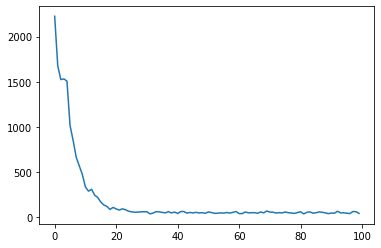

In [135]:
plt_losses(losses)

epcho: 1   loss: 0.12090188
w: [[ 4.1226296 -3.1506357]]  b:  [4.876396]


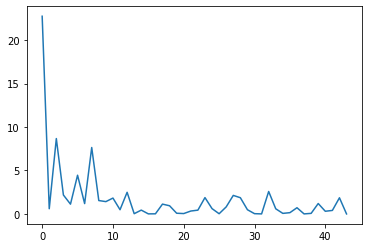

In [142]:
## 随机梯度下降
losses = trainer(x,y,1,1,0.1)
plt_losses(losses[6:50])

In [143]:
## 梯度下降
losses = trainer(x,y,10,1000,0.5)

epcho: 1   loss: 7008.0996
epcho: 2   loss: 2239.1064
epcho: 3   loss: 964.97406
epcho: 4   loss: 622.24426
epcho: 5   loss: 529.4192
epcho: 6   loss: 504.10428
epcho: 7   loss: 497.15265
epcho: 8   loss: 495.2304
epcho: 9   loss: 494.69525
epcho: 10   loss: 494.5453
w: [[ 4.0409393 -3.0137239]]  b:  [5.011294]


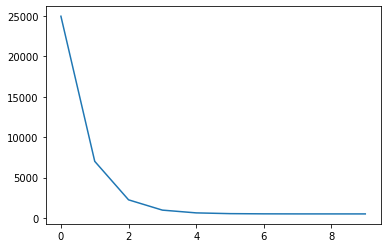

In [144]:
plt_losses(losses)